In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_volumen,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

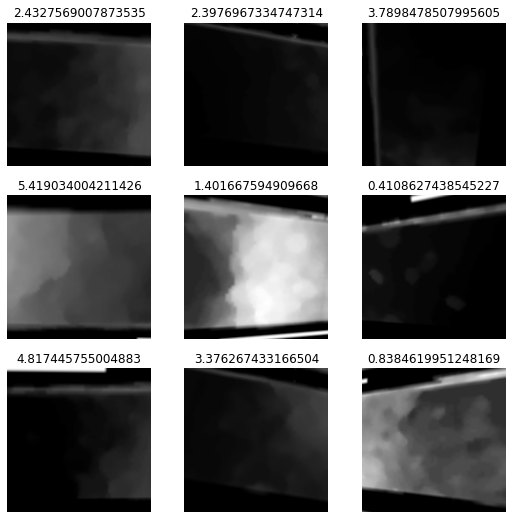

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='convnext_base_Volumen_Height')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('convnext_base',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,11.487593,5.852788,1.899101,2.419254,5.852788,00:06


Better model found at epoch 0 with valid_loss value: 5.85278844833374.


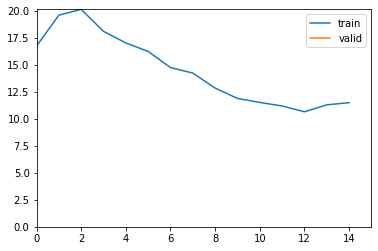

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,6.343409,2.908859,1.505474,1.705538,2.908859,00:05
1,4.471972,1.615804,1.062496,1.271143,1.615804,00:06
2,3.572491,0.872911,0.730951,0.934297,0.872911,00:05
3,2.967084,0.785596,0.699878,0.886339,0.785596,00:06
4,2.487643,0.660294,0.640952,0.812585,0.660294,00:06
5,2.201418,0.463243,0.532550,0.680619,0.463243,00:05
6,1.925195,0.403297,0.473364,0.635057,0.403297,00:06
7,1.732513,0.422681,0.535950,0.650139,0.422681,00:06
8,1.618771,0.308297,0.493409,0.555245,0.308297,00:06
9,1.521363,0.809955,0.700292,0.899975,0.809955,00:06


Better model found at epoch 0 with valid_loss value: 2.9088587760925293.


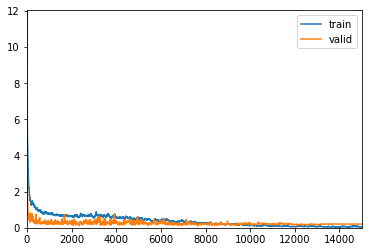

Better model found at epoch 1 with valid_loss value: 1.6158039569854736.
Better model found at epoch 2 with valid_loss value: 0.8729113340377808.
Better model found at epoch 3 with valid_loss value: 0.7855958938598633.
Better model found at epoch 4 with valid_loss value: 0.6602940559387207.
Better model found at epoch 5 with valid_loss value: 0.46324262022972107.
Better model found at epoch 6 with valid_loss value: 0.40329718589782715.
Better model found at epoch 8 with valid_loss value: 0.30829712748527527.
Better model found at epoch 21 with valid_loss value: 0.24824559688568115.
Better model found at epoch 25 with valid_loss value: 0.22403974831104279.
Better model found at epoch 31 with valid_loss value: 0.20984244346618652.
Better model found at epoch 55 with valid_loss value: 0.2025769054889679.
Better model found at epoch 58 with valid_loss value: 0.18607701361179352.
Better model found at epoch 80 with valid_loss value: 0.1813245266675949.
Better model found at epoch 121 with v

In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
# learn.load('convnext_base_Masa_Height')

In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_volumen,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=8)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4185521900653839.


(#4) [0.3301093280315399,0.4185521900653839,0.5745514035224915,0.3301093280315399]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

0.42222923